# Setup for AWS

Our AWS setup typically looks like the following diagram. Each AWS account has
an EKS cluster within an isolated VPC which also contains an RDS, Redis, and any
other resources.

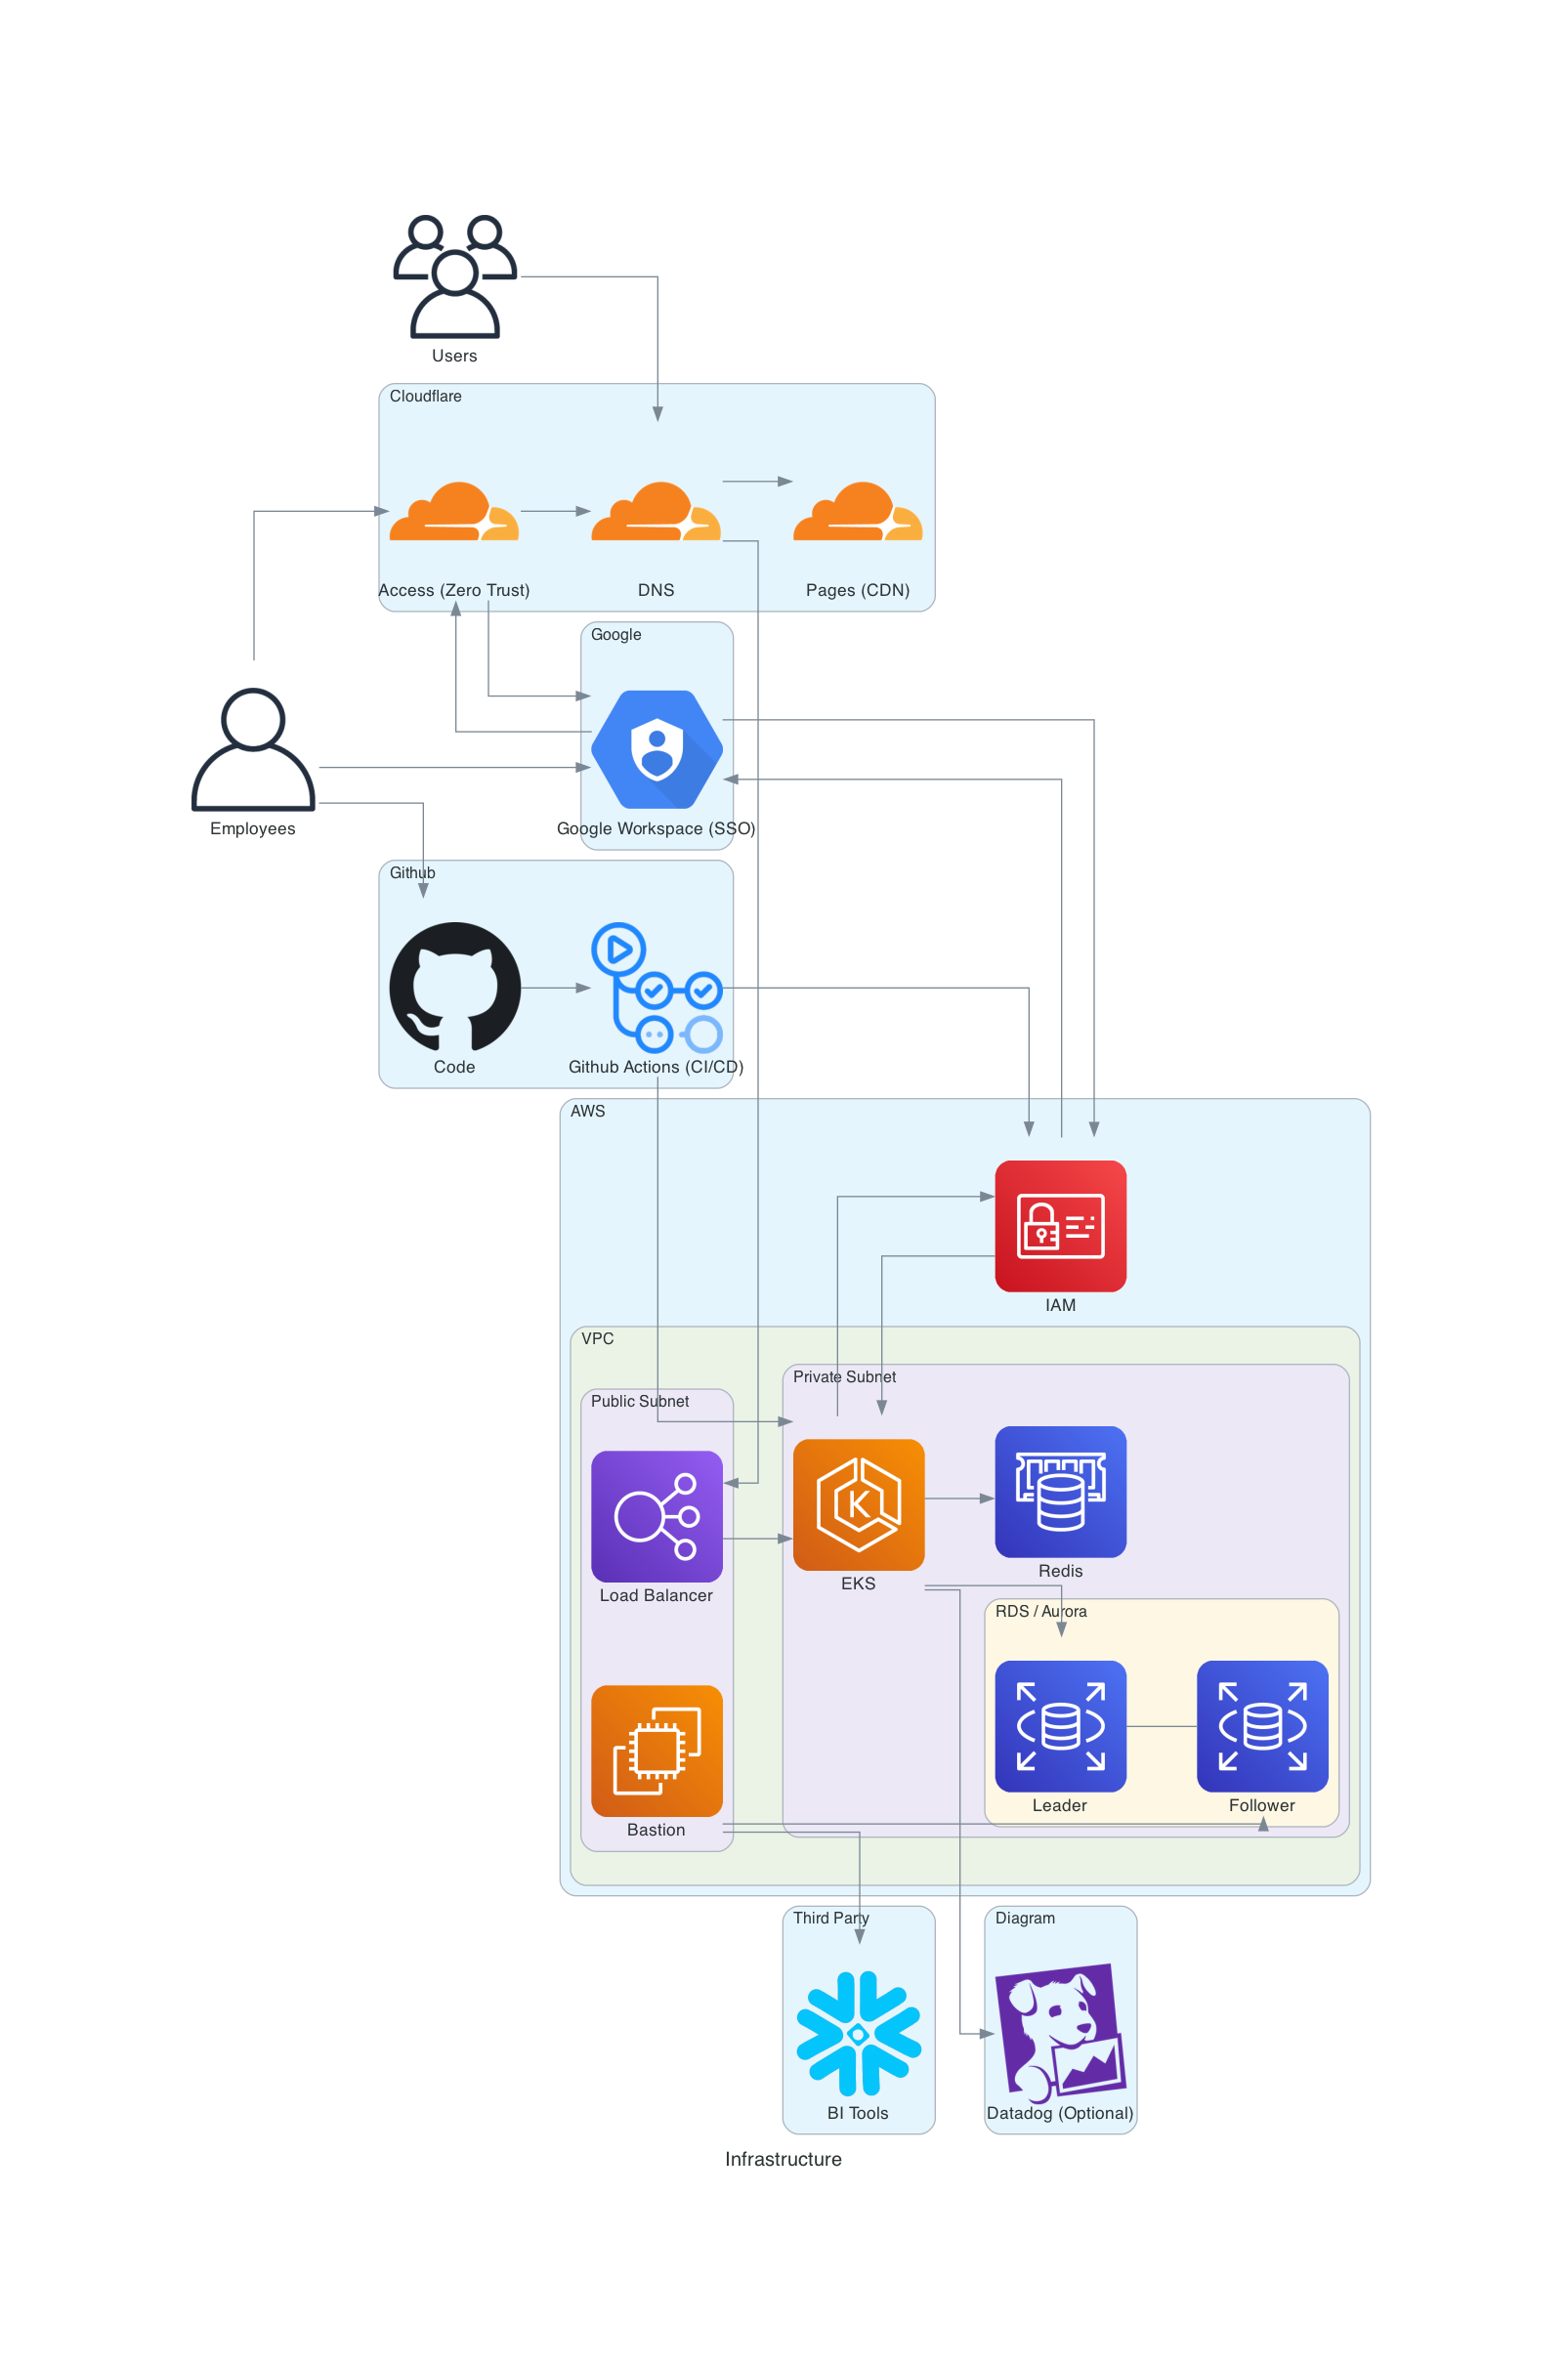

In [9]:
%%capture --no-display

from diagrams import Cluster, Diagram
from diagrams.aws.compute import EC2, ElasticKubernetesService
from diagrams.aws.database import RDS, ElastiCache
from diagrams.aws.general import OfficeBuilding, Users, User
from diagrams.aws.network import ELB, Route53
from diagrams.aws.security import IAM
from diagrams.gcp.security import Iam
from diagrams.generic.device import Mobile
from diagrams.onprem.ci import GithubActions
from diagrams.onprem.monitoring import Datadog
from diagrams.onprem.vcs import Github
from diagrams.saas.cdn import Cloudflare
from diagrams.saas.analytics import Snowflake



with Diagram("Infrastructure", show=False) as diag:
    user = Users("Users")
    employee = User("Employees")

    with Cluster("Cloudflare"):
        dns = Cloudflare("DNS")
        pages = Cloudflare("Pages (CDN)")
        access = Cloudflare("Access (Zero Trust)")

    with Cluster("Google"):
        sso = Iam("Google Workspace (SSO)")

    with Cluster("Github"):
        github = Github("Code")
        github_actions = GithubActions("Github Actions (CI/CD)")

    with Cluster("AWS Account"):
        iam = IAM("IAM")

        with Cluster("VPC"):
            with Cluster("Public Subnet"):
                lb = ELB("Load Balancer")

                bastion = EC2("Bastion")

            with Cluster("Private Subnet"):
                eks = ElasticKubernetesService("EKS")

                with Cluster("RDS / Aurora"):
                    db_master = RDS("Leader")
                    db_follower = RDS("Follower")
                    db_master - [db_follower]

                redis = ElastiCache("Redis")


    with Cluster("Diagram"):
        datadog = Datadog("Datadog (Optional)")

    with Cluster("Third Party"):
        bi = Snowflake("BI Tools")

    dns >> lb >> eks
    dns >> pages

    eks >> db_master
    eks >> redis
    eks >> iam >> eks
    iam >> sso >> iam

    employee >> access >> dns
    employee >> github
    employee >> sso
    access >> sso >> access

    github >> github_actions >> [iam, eks]

    eks >> datadog

    bastion >> db_follower
    bastion >> bi

    user >> dns


diag


## Kubespot

[Kubespot for AWS](https://github.com/opszero/terraform-aws-kubespot/) is our
Terraform configuration the sets up Kubernetes with best practices covering
everything needed for SOC2, HIPAA, and PCI-DSS. This package covers Kubernetes
security while also ensuring developer productivity.

```terraform
terraform {
  backend "s3" {
    bucket  = "opszero-axiom-ai-terraform-tfstate"
    region  = "us-east-1"
    profile = "axiom-ai"
    encrypt = "true"

    key = "cluster/axiom-laravel"
  }
}

provider "aws" {
  profile = "awsprofile"
  region  = "eu-west-1"  # TODO: Change this region
}

provider "helm" {
  kubernetes {
    config_path = "./kubeconfig"
  }
}

provider "kubernetes" {
  config_path = "./kubeconfig"
}

locals {
  environment_name = "axiom-laravel"
}

module "opszero-eks" {
  source = "github.com/opszero/terraform-aws-kubespot"

  zones = [
    "eu-west-1a",
    "eu-west-1b"
  ]

  cluster_version  = "1.29"
  environment_name = local.environment_name
  iam_users = {
    "opszero" = {
      rbac_groups = [
        "system:masters"
      ]
    },
    "cicd-laravel" = {
      rbac_groups = [
        "system:masters"
      ]
    },
    "jenkins" = {
      rbac_groups = [
        "system:masters"
      ]
    },
    "yaseer" = {
      rbac_groups = [
        "system:masters"
      ]
    },
    "simonwilliams" = {
      rbac_groups = [
        "system:masters"
      ]
    },
    "mattnorman" = {
      rbac_groups = [
        "system:masters"
      ]
    },
    "mattnorman" = {
      rbac_groups = [
        "system:masters"
      ]
    }
  }

  cidr_block = "10.3.0.0/16"
  cidr_block_public_subnet = [
    "10.3.0.0/18",
    "10.3.64.0/18",
  ]
  cidr_block_private_subnet = [
    "10.3.128.0/18",
    "10.3.192.0/18",
  ]

  nat_enabled = true

  node_groups = {
    "blue" = {
      instance_types         = ["t3.medium", "t3a.medium"]
      capacity_type          = "SPOT"
      nodes_in_public_subnet = false,
      node_disk_size         = 20,
      node_desired_capacity  = 2,
      nodes_max_size         = 2,
      nodes_min_size         = 2,
    }

    "green" = {
      instance_types         = ["t3.medium", "t3a.medium"]
      capacity_type          = "ON_DEMAND"
      nodes_in_public_subnet = false,
      node_disk_size         = 20,
      node_desired_capacity  = 2,
      nodes_max_size         = 2,
      nodes_min_size         = 2,
    }
  }

  redis_enabled        = false
  sql_cluster_enabled  = false
  sql_instance_enabled = false

  vpc_flow_logs_enabled = false

  efs_enabled = false

  cloudwatch_pod_logs_enabled = true
}

resource "aws_ecr_repository" "laravel" {
  name                 = "axiom-laravel"
  image_tag_mutability = "MUTABLE"

  image_scanning_configuration {
    scan_on_push = true
  }
}

module "wildcard-cert" {
  source = "../shared/certs"
}

```

### IAM 

AWS IAM is configured with [MrMgr](https://github.com/opszero/terraform-aws-mrmgr) an open source library to configure IAM Roles, Github OIDC permissions, and IAM Users.

 - IAM Roles are configured to give the least access to your team while still allowing for productivity.
 - [Github OIDC](https://docs.github.com/en/actions/deployment/security-hardening-your-deployments/configuring-openid-connect-in-amazon-web-services). Github gets access to your AWS account through OIDC. AWS provides temporary tokens to Github for deployment scoped at the repository level, requiring no additional IAM users to be created.
 - IAM Users are created if needed for access outside of SSO.

#### Google Workspace

Google Workspace provides a Single-Sign On solution, which simplifies access to
your Cloud resources by using a single set of credentials. This can be
beneficial in quickly managing user access to your infrastructure, as users can
be added or removed with ease.

 - [How to use G Suite as an external identity provider for AWS SSO](https://aws.amazon.com/blogs/security/how-to-use-g-suite-as-external-identity-provider-aws-sso/)

We can also setup other identity providers such as Okta.


### VPCs

Every environment we set up for you will be within its own VPC. You can think of
a VPC as similar to the wireless router you connect to at home. The wireless
router and cable modem act as a bridge to the outside network, and VPCs work in
a similar way. We follow best practices to set up VPCs with high security
standards that ensure all resources are created behind a NAT. A NAT acts like a
static IP that all external resources see when you send data out of your
network. If desired, we can also put things into the public subnet, although
this is not recommended except for bastions. The VPCs are even locked down
within the same AWS account, limiting intruder access to
resources.

### EKS (Kubernetes)

Environments and deployments are setup using Kubernetes. There are a range of
opinions about Kubernetes, but we have been developing and deploying software
for well over a decade and believe a well configured Kubernetes cluster will
just work and scale as your grow. We configure your Kubernetes cluster with just
the appropriate amount of built in tooling to reduce costs, be performant, and
scale. Deploy software as many times as you want during the day with no downtime
deploys.  Further, we are able to upgrade your clusters without any downtime
whatsoever.

### RDS / Aurora

Databases are either RDS or Aurora are configured with configurations for data
encryption and solid security postures.